In [2]:
import warnings
warnings.filterwarnings("ignore", message="'has_mps' is deprecated")


In [3]:
from fastai.vision.all import *

# Path to your dataset
path = Path(r'F:\Data Science\Computer Vision loyixa\3.27 belgini aniqlovchi\yolov5\data\stop_signs')

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(224),  # This ensures all images are resized to 224x224
    batch_tfms=aug_transforms()
)

# Create DataLoaders
dls = dblock.dataloaders(path, bs=16)




In [4]:
# Create the Learner
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Fine-tune the model
learn.fine_tune(4)

c:\Users\Asus\anaconda3\Lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,00:14
1,0.000000,0.000000,1.000000,00:13
2,0.000000,0.000000,1.000000,00:15
3,0.000000,0.000000,1.000000,00:13


In [5]:
learn.export('stop_sign_model.pkl')


# Trasnport Aniqlovchi model:

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,02:54


epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,04:30
1,0.000000,0.000000,1.000000,04:24


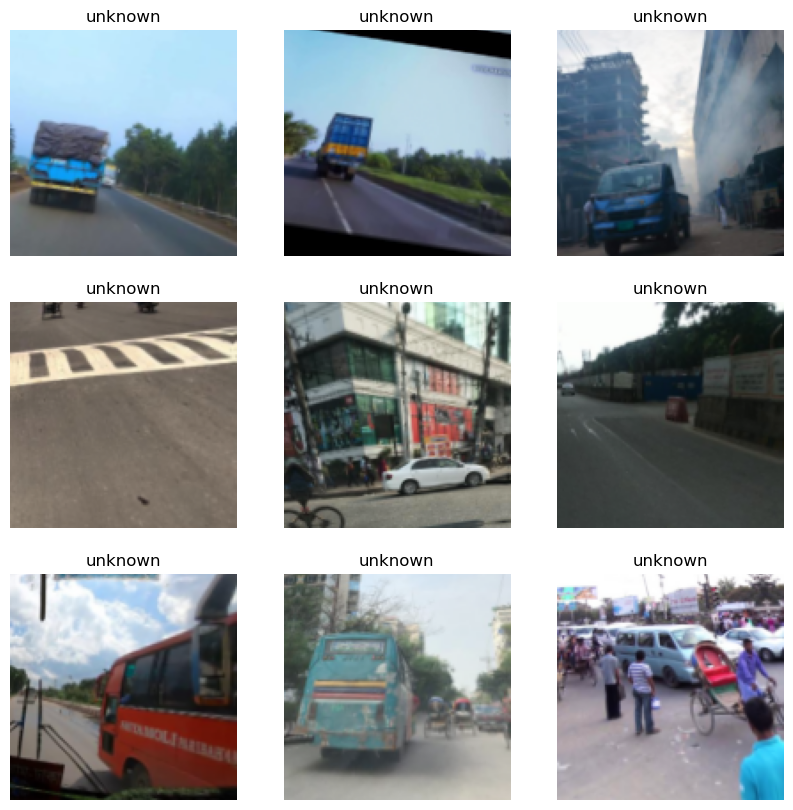

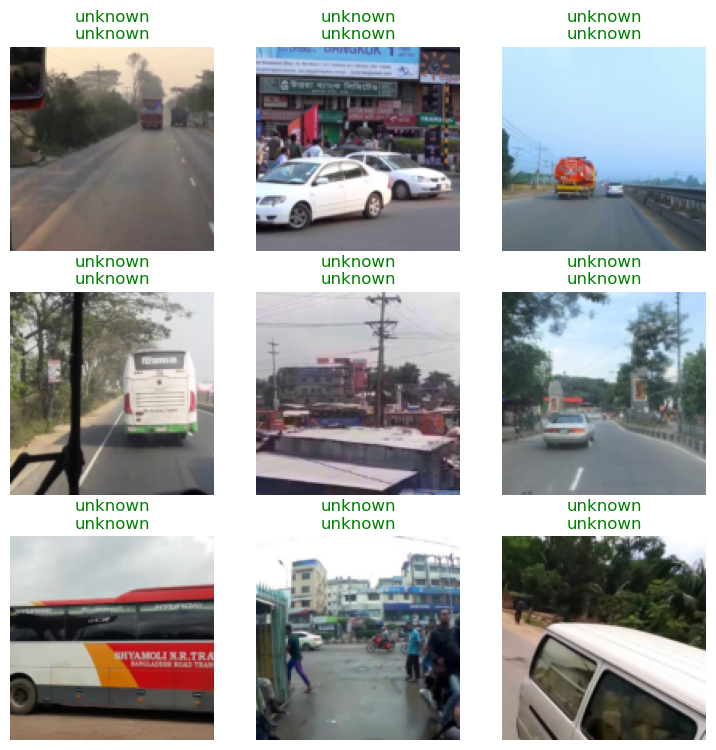

In [18]:
from fastai.vision.all import *

# Ma'lumotlar saqlangan joy
path = Path(r'F:\Data Science\Computer Vision loyixa\3.27 belgini aniqlovchi\yolov5\data\transports\trafic_data\train')

# Tasvirlar va ularning tegishli toifalari
def get_y(fname):
    if 'car' in fname.name:
        return 'car'
    elif 'bus' in fname.name:
        return 'bus'
    elif 'truck' in fname.name:
        return 'truck'
    else:
        return 'unknown'

# DataBlock yaratish
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 20% validatsiya ma'lumotlari
    item_tfms=Resize(128),  # Tasvirlarni 128x128 ga o'zgartirish
    batch_tfms=aug_transforms()  # Ma'lumotlarga o'zgarishlar qo'shish
)

# DataLoader yaratish
dls = dblock.dataloaders(path, bs=16)

# DataLoader'ni tekshirish
dls.show_batch(max_n=9, figsize=(10, 10))

# Model yaratish
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Modelni o'qitish
learn.fine_tune(2)  # 4 epoch uchun o'qitish

# Modelni sinash
learn.show_results()

# Modelni saqlash
learn.save('model')  # Modelni saqlash

# Modelni yuklash va sinash
learn.load('model')


In [22]:
learn.export('vehicle-model.pkl')


In [39]:
import cv2
import torch
from fastai.vision.all import *
import asyncio
import websockets
from pathlib import Path

# Modelni yuklash
stop_sign_model = load_learner('stop_sign_model.pkl')
vehicle_model = cnn_learner(dls, resnet34, metrics=accuracy)
vehicle_model.load('model')

# WebSocket serverga xabar yuborish
async def send_event():
    uri = "ws://your-websocket-server-address"  # WebSocket server manzilini o'zgartiring
    async with websockets.connect(uri) as websocket:
        await websocket.send("Vehicle detected for more than 10 seconds")

# Video oqimini ochish
cap = cv2.VideoCapture(0)

stop_sign_detected = False
vehicle_detected_start_time = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Tasvirni PILImage formatida o'zgartirish
    img = PILImage.create(frame)

    # 3.27 'No Stopping' belgisini aniqlash
    stop_sign_pred = predict_image(img, stop_sign_model)
    if stop_sign_pred == 'stop_sign':
        stop_sign_detected = True
        print("3.27 'No Stopping' sign detected.")
    else:
        stop_sign_detected = False
        vehicle_detected_start_time = None  # Agar belgi aniqlanmasa, vaqtni reset qiling

    if stop_sign_detected:
        # Transport vositasini aniqlash
        vehicle_pred = predict_image(img, vehicle_model)
        if vehicle_pred in ['car', 'bus', 'truck']:
            if vehicle_detected_start_time is None:
                vehicle_detected_start_time = cv2.getTickCount()
            else:
                elapsed_time = (cv2.getTickCount() - vehicle_detected_start_time) / cv2.getTickFrequency()
                if elapsed_time > 10:
                    # WebSocket hook yuborish
                    print("Vehicle detected for more than 10 seconds. Sending event.")
                    asyncio.run(send_event())
        else:
            vehicle_detected_start_time = None

    # Natijani ko'rsatish
    cv2.imshow('Output', frame)

    # 'q' tugmasini bosganda chiqish
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


NameError: name 'elapsed_time' is not defined